출처 : [pytorch-datasets-and-dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

데이터를 처리하는 코드는 쉽게 지저분해지고 유지보수하기가 어렵다; PyTorch는 읽기 쉬우면서 모듈성을 위해 dataset 코드를 모델 학습 코드와 분리하기를 원했다. Pytorch는 2가지 데이터 기본요소를 제공한다: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. 이 라이브러리는 가지고 있는 자체 데이터를 쓸 수 있을 뿐만 아니라 사전 로드된 dataset을 사용할 수 있다. `Dataset`은 샘플과 그에 대응되는 레이블을 저장하고, `DataLoader`는 `Dataset`을 iterable로 감싸 샘플에 쉽게 접근하도록 한다.  
  
PyTorch 도메인 라이브러리들은 수많은 사전로드된 dataset을 제공하며(FashionMNIST와 같은), 이 dataset은 `torch.utils.data.Dataset`을 상속하고 특정 데이터에 대한 특별한 함수를 구현한다. 이 dataset은 모델을 프로토타이핑 및 벤치마크에 쓸 수 있다. 여기 참고 : [Image Datasets](https://pytorch.org/vision/stable/datasets.html), [Text Datasets](https://pytorch.org/text/stable/datasets.html), [Audio Datasets](https://pytorch.org/audio/stable/datasets.html)  

## Loading a Dataset
예시로 TorchVision의 [Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/) dataset를 사용하자. Fasion-MNIST는 6만 개의 training 샘플과 만 개의 test 샘플을 포함하는 Zalando(독일의 패션 소매 기업) 기사 이미지 dataset이다. 각 샘플은 28x28 크기의 grayscale 이미지로 구성되어 있고 10개의 클래스 중 하나의 레이블을 가진다.  
  
다음과 같은 parameters를 가지고 [FashionMNIST Dataset](https://pytorch.org/vision/stable/datasets.html#fashion-mnist)을 로드할 수 있다.

- `root` 는 train/test 데이터가 저장될 경로
- `train` 은 training dataset인 지 test dataset 인지 결정
- `download=True` 는 `root` 경로에 없을 경우 인터넷으로 다운 받을 지 결정
- `transform`과 `target_transform`은 각각 feature와 label 변환을 지정

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## Iterating and Visualizing the Dataset
list처럼 `Datasets`에 index로 접근할 수 있다. `matplotlib`을 사용해 몇몇 샘플을 살펴보면 다음과 같다.

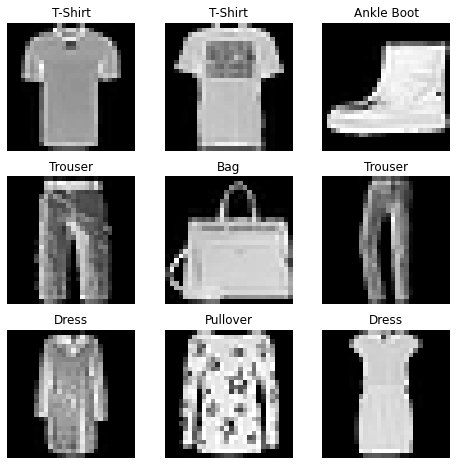

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Creating a Custom Dataset for your files
`Dataset` class를 커스텀 하려면 3개의 함수를 반드시 구현해야 한다: `__init__`, `__len__`, 그리고 `__getitem__`. FashionMNIST 이미지는 `img_dir`에 저장되어 있고, 레이블은 `annotations_file`에 저장되어 있자고 하자.  
  
- `__init__` 함수는 Dataset 객체를 초기화할 때 한번 실행된다. 이미지와 레이블 파일이 있는 directory와 transform을 초기화한다.
- `__len__` 함수는 dataset의 샘플 수를 리턴한다.
- `__getitem__` 함수는 `idx`를 가지고 dataset의 하나의 샘플을 로드하고 리턴한다. index를 가지고 이미지의 위치를 찾은 다음, `read_image`를 사용해 tensor로 변환한다. 그 다음에는 대응되는 레이블을 `self.img_labels`에서 찾은 후 적용할 transfrom 함수고 있다면 적용한다. 마지막에 이미지 tensor와 레이블 tuple을 리턴한다.

In [3]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Preparing your data for training with DataLoaders
`Dataset`은 dataset의 features와 label을 한번에 하나씩 찾는다. 모델 학습중에는 샘플들을 minibatches로 전달하거나, 모델의 오버피팅을 줄이기 위해 epoch마다 데이터를 reshuffle하거나, 더 빠른 데이터 검색을 위해 Python의 `multiprocessing`을 사용하고 싶기도 한다.  
  
`DataLoader`는 이 기능들을 쉽게 구현한 iterable이다.

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Iterate through the DataLoader
dataset을 `DataLoader`에 전달하면 필요한 만큼 반복할 수 있다. 각 반복(iteration)마다 `train_features`와 `train_labels` batch를 리턴한다. (`batch_size=64` features와 labels 각각). `shuffle=True`로 지정하면 모든 배치가 끝날때 마다 데이터가 셔플된다. (finer-grained control은 [Samplers](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) 참고)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


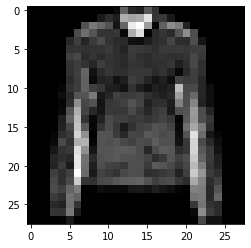

Label: 4


In [5]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")